In [1]:
import pandas as pd
import numpy as np

from torch_geometric.data import Dataset, Data
from torch_geometric.transforms import NormalizeFeatures

from torchmetrics import ConfusionMatrix, AUROC, F1Score, Precision, Recall

# PyTorch Lightning
import pytorch_lightning as pl

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor

# PyTorch geometric
import torch_geometric
import torch_geometric.data as geom_data
import torch_geometric.nn as geom_nn

#Wandb
import wandb

# PL callbacks
from pytorch_lightning.callbacks import ModelCheckpoint

import os
from tqdm import tqdm

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
pl.seed_everything(42)
torch.manual_seed(42)

Seed set to 42


In [2]:
MIN_DISEASE_S_GENE_NUMBER = 0
TEST_TRAIN_SPLIT = 0.5
TEST_VAL_SPLIT = 0.5

EPOCHS = 10
AVAIL_GPUS = min(1, torch.cuda.device_count())

CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "data/saved_models/")
gnn_layer_by_name = {"GCN": geom_nn.GCNConv, "GAT": geom_nn.GATConv, "GraphConv": geom_nn.GraphConv}

wandb.login(key="e1f878235d3945d4141f9f8e5af41d712fca6eba")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: nemes-attila (nemes-attila-budapesti-m-szaki-s-gazdas-gtudom-nyi-egyetem). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Nemes\_netrc


True

In [3]:
class IdMapper():
    sorted_diseases = []
    sorted_genes = []

    def __init__(self, gene_file, disease_file):
        genes = pd.read_csv(gene_file, sep="\t")
        self.genes = genes["genes"].sort_values().unique()

        disieses = pd.read_csv(disease_file, sep="\t")
        diseases_filtered = disieses.groupby("diseaseId").filter(lambda x: len(x) > MIN_DISEASE_S_GENE_NUMBER)
        self.diseases = diseases_filtered["diseaseId"].sort_values().unique()

    def diseases_idx_to_id_map(self):
        return { idx: item  for idx, item in enumerate(self.diseases)}

    def diseases_id_to_idx_map(self):
        return { item: idx  for idx, item in enumerate(self.diseases)}

    def genes_idx_to_id_map(self):
        return { idx: item  for idx, item in enumerate(self.genes)}

    def genes_id_to_idx_map(self):
        return { item: idx  for idx, item in enumerate(self.genes)}

In [4]:
class GeneDataset(Dataset):
    def __init__(self, root, filenames, test_size, val_size, test=False, transform=None, pre_transform=None):
        """
        root = Where the dataset should be stored. This folder is split
        into raw_dir (downloaded dataset) and processed_dir (processed data).
        """
        self.test = test
        self.test_size = test_size
        self.val_size = val_size
        self.filenames = filenames
        self.mapper = IdMapper("./data/raw/"+filenames[0], "./data/raw/"+filenames[2])
        super(GeneDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        """ If this file exists in raw_dir, the download is not triggered.
            (The download func. is not implemented here)
        """
        return self.filenames

    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped"""
        if self.test:
            return [F'{file_name}_test' for file_name in self.raw_paths]
        else:
            return self.raw_paths

    def download(self):
        pass

    def process(self):
        self.genes_features = pd.read_csv(self.raw_paths[0], sep="\t")
        self.edges_features = pd.read_csv(self.raw_paths[1], sep="\t")
        self.disiese_gene_matrix = pd.read_csv(self.raw_paths[2], sep="\t")

        self.genes = self.genes_features["genes"].sort_values().unique()
        self.diseases = self.disiese_gene_matrix["diseaseId"].sort_values().unique()

        node_feats = self._get_node_features(self.genes_features)
        edge_feats = self._get_edge_features(self.edges_features)
        edge_index = self._get_adjacency_info(self.edges_features)

        y = self._create_mask_matrix(self.disiese_gene_matrix.copy()).to(torch.float32)
        train_mask, validation_mask, test_mask = self._get_train_val_test_mask(self.disiese_gene_matrix.copy())

        data = Data(x=node_feats,
                    edge_index=edge_index,
                    edge_weight=edge_feats,
                    test_mask=test_mask, val_mask=validation_mask, train_mask=train_mask, y=y)

        if self.test:
            torch.save(data, os.path.join(self.processed_dir, 'graph_test.pt'))
        else:
            torch.save(data, os.path.join(self.processed_dir, 'graph.pt'))


    def _get_train_val_test_mask(self, disiese_gene_matrix):
        """
        i need too create matrices shape like disgenet
        and in this matrix i pick random points which are gonna be the train mask, validation mask and test mask

        in the train dataset i need to pick 80% from disgenet, equaly 0s and 1s in a column
        in the validation dataset i need to pick 10% from disgenet, equaly 0s and 1s in a column
        """

        train, validation, test = self._split_labels_to_train_val_test(disiese_gene_matrix)
        disgenet_inverse = self._get_disgenet_inverse(disiese_gene_matrix)
        train_n, validation_n, test_n = self._split_labels_to_train_val_test(disgenet_inverse)
        train_r = pd.concat([train, train_n], ignore_index=True)
        validation_r = pd.concat([validation, validation_n], ignore_index=True)
        test_r = pd.concat([test, test_n], ignore_index=True)

        train_mask = self._create_mask_matrix(train_r)
        validation_mask = self._create_mask_matrix(validation_r)
        test_mask = self._create_mask_matrix(test_r)

        return train_mask, validation_mask, test_mask

    def _split_labels_to_train_val_test(self, disgenet: pd.DataFrame):
        #Split the positive targets to equal partitions by disease
        disgenet_grouped = disgenet.groupby(by="diseaseId", group_keys=False)
        test_validation = disgenet_grouped.apply(lambda x: x.sample(frac=TEST_TRAIN_SPLIT, random_state=1))
        train = disgenet.drop(test_validation.index)
        test_validation_grouped = test_validation.groupby(by="diseaseId", group_keys=False)

        #Group by is needed before sample function call!!!
        test = test_validation_grouped.apply(lambda x: x.sample(frac=TEST_VAL_SPLIT, random_state=1))
        drop_indices = pd.concat([train, test]).index
        validation = disgenet.drop(drop_indices)
        return train, validation, test


    def _get_disgenet_inverse(self, disgenet):
        genes_frame = pd.DataFrame(list(self.genes), columns=["geneId"])
        diseases_frame = pd.DataFrame(self.diseases, columns=["diseaseId"])
        gene_disease_descartes_product = genes_frame.merge(diseases_frame, how="cross")
        disgenet_inverse = gene_disease_descartes_product.merge(disgenet, on=['geneId', 'diseaseId'], how='left', indicator=True)
        return disgenet_inverse[disgenet_inverse['_merge'] == 'left_only'].drop(columns='_merge')


    def _create_mask_matrix(self, dataframe):
        dataframe_for_matrix = pd.DataFrame(np.zeros((len(self.genes), len(self.diseases)),))
        gene_id_to_idx = self.mapper.genes_id_to_idx_map()
        disease_id_to_idx = self.mapper.diseases_id_to_idx_map()

        dataframe["geneId"] = dataframe["geneId"].map(gene_id_to_idx)
        dataframe["diseaseId"] = dataframe["diseaseId"].map(disease_id_to_idx)
        tuples_array = [row for row in dataframe.itertuples(index=False, name=None)]
        for row, col in tqdm(tuples_array):
            dataframe_for_matrix.loc[row, col] = 1

        return torch.tensor(dataframe_for_matrix.to_numpy(), dtype=torch.bool)

    def _get_node_features(self, genes):
        gene_id_to_idx = self.mapper.genes_id_to_idx_map()
        genes["genes"] = self.genes_features["genes"].map(gene_id_to_idx)
        all_node_feats = genes.values.tolist()
        all_node_feats = np.asarray(all_node_feats)

        return torch.tensor(all_node_feats, dtype=torch.float32)

    def _get_edge_features(self, edges):
        """
        This will return a matrix / 2d array of the shape
        [Number of edges, Edge Feature size]
        """
        duplicated_edges = edges.loc[edges.index.repeat(2)].reset_index(drop=True)
        all_edge_feats = duplicated_edges["combined_score"].tolist()
        return torch.tensor(all_edge_feats, dtype=torch.float32)


    def _get_adjacency_info(self, edges):
        """
        We want to be sure that the order of the indices
        matches the order of the edge features
        """
        gene_id_to_idx = self.mapper.genes_id_to_idx_map()

        edge_indices = []
        gene_1 = edges["gene1"].map(gene_id_to_idx)
        gene_2 = edges["gene2"].map(gene_id_to_idx)
        edges = pd.concat([gene_1, gene_2], axis=1).values.tolist()

        #iterate over the edges end duplicate it because for one edge we need: n1,n2 and n2,n1
        double_edges = []
        for edge in edges:
            double_edges += [ edge, [edge[1], edge[0]]]

        edge_indices = torch.tensor(double_edges)
        edge_indices = edge_indices.t().to(torch.int32).view(2, -1)
        return edge_indices

    def len(self):
        return self.genes.shape[0]

    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        if self.test:
            graph = torch.load(os.path.join(self.processed_dir, 'graph_test.pt'), weights_only=False)
        else:
            graph = torch.load(os.path.join(self.processed_dir, 'graph.pt'), weights_only=False)

        return graph

    def __getitem__(self, idx):
        return self.get(0)

In [5]:
dataset = GeneDataset(
    root="./data",
    filenames=["gtex_genes_test.csv", "gene_graph_test.csv", "disgenet_test.csv"],
    test_size=0.2,
    val_size=0.0,
    transform=NormalizeFeatures())

Processing...
100%|██████████| 11/11 [00:00<00:00, 10966.80it/s]
C:\Users\Nemes\AppData\Local\Temp\ipykernel_15056\3127019212.py:83: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_validation = disgenet_grouped.apply(lambda x: x.sample(frac=TEST_TRAIN_SPLIT, random_state=1))
C:\Users\Nemes\AppData\Local\Temp\ipykernel_15056\3127019212.py:88: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test = test_valid

disgenetet úgy tovább szűrni, hogy az egyes betegséghez legalább x gén tartozzon --> végén majd kiprobálni, hogy nem szürök rajtuk

GCN --> a veszteség függvény legyen jó, sima bináris osztályozás

keresztvalidáció

mátrixokkal dolgozzak

ha kiegyensulyozatlan akkor --> f1 score, avg precision, precision-recall görbe, (olyan metrikákat használjak)
                                    dúsitást NEEEE


In [6]:
class GCNLayer(torch.nn.Module):
    def __init__(self, c_in, c_out):
        super().__init__()
        self.projection = torch.nn.Linear(c_in, c_out)

    def forward(self, node_feats, adj_matrix):
        """Forward.

        Args:
            node_feats: Tensor with node features of shape [batch_size, num_nodes, c_in]
            adj_matrix: Batch of adjacency matrices of the graph. If there is an edge from i to j,
                         adj_matrix[b,i,j]=1 else 0. Supports directed edges by non-symmetric matrices.
                         Assumes to already have added the identity connections.
                         Shape: [batch_size, num_nodes, num_nodes]

        """
        # Num neighbours = number of incoming edges
        num_neighbours = adj_matrix.sum(dim=-1, keepdims=True)
        node_feats = self.projection(node_feats)
        node_feats = torch.bmm(adj_matrix, node_feats)
        node_feats = node_feats / num_neighbours
        return node_feats

In [7]:
class GATLayer(nn.Module):
    def __init__(self, c_in, c_out, num_heads=1, concat_heads=True, alpha=0.2):
        """
        Args:
            c_in: Dimensionality of input features
            c_out: Dimensionality of output features
            num_heads: Number of heads, i.e. attention mechanisms to apply in parallel. The
                        output features are equally split up over the heads if concat_heads=True.
            concat_heads: If True, the output of the different heads is concatenated instead of averaged.
            alpha: Negative slope of the LeakyReLU activation.
        """
        super().__init__()
        self.num_heads = num_heads
        self.concat_heads = concat_heads
        if self.concat_heads:
            assert c_out % num_heads == 0, "Number of output features must be a multiple of the count of heads."
            c_out = c_out // num_heads

        # Sub-modules and parameters needed in the layer
        self.projection = nn.Linear(c_in, c_out * num_heads)
        self.a = nn.Parameter(Tensor(num_heads, 2 * c_out))  # One per head
        self.leakyrelu = nn.LeakyReLU(alpha)

        # Initialization from the original implementation
        nn.init.xavier_uniform_(self.projection.weight.data, gain=1.414)
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

    def forward(self, node_feats, adj_matrix, print_attn_probs=False):
        """Forward.

        Args:
            node_feats: Input features of the node. Shape: [batch_size, c_in]
            adj_matrix: Adjacency matrix including self-connections. Shape: [batch_size, num_nodes, num_nodes]
            print_attn_probs: If True, the attention weights are printed during the forward pass
                               (for debugging purposes)

        """
        batch_size, num_nodes = node_feats.size(0), node_feats.size(1)

        # Apply linear layer and sort nodes by head
        node_feats = self.projection(node_feats)
        node_feats = node_feats.view(batch_size, num_nodes, self.num_heads, -1)

        # We need to calculate the attention logits for every edge in the adjacency matrix
        # Doing this on all possible combinations of nodes is very expensive
        # => Create a tensor of [W*h_i||W*h_j] with i and j being the indices of all edges
        # Returns indices where the adjacency matrix is not 0 => edges
        edges = adj_matrix.nonzero(as_tuple=False)
        node_feats_flat = node_feats.view(batch_size * num_nodes, self.num_heads, -1)
        edge_indices_row = edges[:, 0] * num_nodes + edges[:, 1]
        edge_indices_col = edges[:, 0] * num_nodes + edges[:, 2]
        a_input = torch.cat(
            [
                torch.index_select(input=node_feats_flat, index=edge_indices_row, dim=0),
                torch.index_select(input=node_feats_flat, index=edge_indices_col, dim=0),
            ],
            dim=-1,
        )  # Index select returns a tensor with node_feats_flat being indexed at the desired positions

        # Calculate attention MLP output (independent for each head)
        attn_logits = torch.einsum("bhc,hc->bh", a_input, self.a)
        attn_logits = self.leakyrelu(attn_logits)

        # Map list of attention values back into a matrix
        attn_matrix = attn_logits.new_zeros(adj_matrix.shape + (self.num_heads,)).fill_(-9e15)
        attn_matrix[adj_matrix[..., None].repeat(1, 1, 1, self.num_heads) == 1] = attn_logits.reshape(-1)

        # Weighted average of attention
        attn_probs = F.softmax(attn_matrix, dim=2)
        if print_attn_probs:
            print("Attention probs\n", attn_probs.permute(0, 3, 1, 2))
        node_feats = torch.einsum("bijh,bjhc->bihc", attn_probs, node_feats)

        # If heads should be concatenated, we can do this by reshaping. Otherwise, take mean
        if self.concat_heads:
            node_feats = node_feats.reshape(batch_size, num_nodes, -1)
        else:
            node_feats = node_feats.mean(dim=2)

        return node_feats

In [8]:
class GNNModel(nn.Module):
    def __init__(
        self,
        c_in,
        c_hidden,
        c_out,
        num_layers=2,
        layer_name="GCN",
        dp_rate=0.1,
        **kwargs,
    ):
        """GNNModel.

        Args:
            c_in: Dimension of input features
            c_hidden: Dimension of hidden features
            c_out: Dimension of the output features. Usually number of classes in classification
            num_layers: Number of "hidden" graph layers
            layer_name: String of the graph layer to use
            dp_rate: Dropout rate to apply throughout the network
            kwargs: Additional arguments for the graph layer (e.g. number of heads for GAT)

        """
        super().__init__()
        gnn_layer = gnn_layer_by_name[layer_name]

        layers = []
        in_channels, out_channels = c_in, c_hidden
        for l_idx in range(num_layers - 1):
            layers += [
                gnn_layer(in_channels=in_channels, out_channels=out_channels, **kwargs),
                nn.ReLU(inplace=True),
                nn.Dropout(dp_rate),
            ]
            in_channels = c_hidden
        layers += [gnn_layer(in_channels=in_channels, out_channels=c_out, **kwargs)]
        self.layers = nn.ModuleList(layers)

    def forward(self, x, edge_index, edge_weight):
        """Forward.

        Args:
            x: Input features per node
            edge_index: List of vertex index pairs representing the edges in the graph (PyTorch geometric notation)

        """
        for layer in self.layers:
            # For graph layers, we need to add the "edge_index" tensor as additional input
            # All PyTorch Geometric graph layer inherit the class "MessagePassing", hence
            # we can simply check the class type.
            if isinstance(layer, geom_nn.MessagePassing):
                x = layer(x, edge_index, edge_weight)
            else:
                x = layer(x)
        return x

In [9]:
# The simple GCN modell
class TestGCN(pl.LightningModule):
    def __init__(self, model_name, **model_kwargs):
        super().__init__()
        self.save_hyperparameters()
        self.loss_module = nn.CrossEntropyLoss()
        self.model = GNNModel(**model_kwargs)

        self.learning_rate=0.01
        self.decay=5e-4

        self.cm = ConfusionMatrix(task="binary", num_classes=2)
        self.aucroc = AUROC(task="binary", num_classes=2)
        self.f1 = F1Score(task="binary", num_classes=2)
        self.precision = Precision(task="binary", num_classes=2)
        self.recall = Recall(task="binary", num_classes=2)

    def forward(self, data, mode="train"):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        new_x = self.model(x, edge_index, edge_weight)

        # Only calculate the loss on the nodes corresponding to the mask
        if mode == "train":
            mask = data.train_mask
        elif mode == "val":
            mask = data.val_mask
        elif mode == "test":
            mask = data.test_mask
        else:
            assert False, f"Unknown forward mode: {mode}"

        loss = self.loss_module(new_x[mask], data.y[mask])
        acc = (new_x[mask].argmax(dim=-1) == data.y[mask]).sum().float() / mask.sum()

        if mode == "test":
            return loss, acc, new_x
        return loss, acc

    def training_step(self, data):
        loss, acc = self.forward(data, mode="train")
        self.log('train_loss', loss, prog_bar=True, on_epoch=True)
        self.log('train_acc', acc, prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, data: GeneDataset):
        loss, acc = self.forward(data, mode="val")
        self.log("val_acc", acc)
        self.log("val_loss", loss)

    def test_step(self, data: GeneDataset):
        loss, acc, x = self.forward(data, mode="test")
        x_masked = x[data.test_mask]
        y_masked = data.y[data.test_mask]

        self.log("test_acc", acc)
        self.log('test_loss', loss, prog_bar=True, on_epoch=True)
        self.cm.update(x_masked, y_masked)
        self.aucroc.update(x_masked, y_masked)
        self.f1.update(x_masked, y_masked)
        self.precision.update(x_masked, y_masked)
        self.recall.update(x_masked, y_masked)
        return loss

    def on_test_epoch_end(self) -> None:
        self.cm.plot()
        self.log('test_auc_roc', self.aucroc.compute(), prog_bar=True, on_epoch=True)
        self.log('test_f1', self.f1.compute(), prog_bar=True, on_epoch=True)
        self.log('test_precision', self.precision.compute(), prog_bar=True, on_epoch=True)
        self.log('test_recall', self.recall.compute(), prog_bar=True, on_epoch=True)
        return super().on_test_epoch_end()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.decay)

In [ ]:
def train_node_classifier(model_name, dataset, **model_kwargs):
    pl.seed_everything(42)
    node_data_loader = geom_data.DataLoader(dataset, num_workers=11, persistent_workers=True)

    # Create a PyTorch Lightning trainer
    root_dir = os.path.join(CHECKPOINT_PATH, "TestGCN" + model_name)
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(
        default_root_dir=root_dir,
        callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
        accelerator="auto",
        devices=1,
        max_epochs=EPOCHS,
        enable_progress_bar=False,
        logger=pl.loggers.WandbLogger(project="gene-disease-test", log_model="all")
    )
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    # pretrained_filename = os.path.join(CHECKPOINT_PATH, f"TestGCN{model_name}.ckpt")
    # if os.path.isfile(pretrained_filename):
    #     print("Found pretrained model, loading...")
    #     model = TestGCN.load_from_checkpoint(pretrained_filename)
    # else:
    pl.seed_everything()
    model = TestGCN(
        model_name=model_name, c_in=dataset.num_node_features, c_out=dataset.num_classes, **model_kwargs
    )
    trainer.fit(model, node_data_loader, node_data_loader)
    model = TestGCN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on the test set
    test_result = trainer.test(model, dataloaders=node_data_loader)
    result = {"test": test_result[0]["test_acc"]}
    wandb.finish()
    return model, result

In [11]:
def print_results(result_dict):
    if "train" in result_dict:
        print("Train accuracy: %4.2f%%" % (100.0 * result_dict["train"]))
    if "val" in result_dict:
        print("Val accuracy:   %4.2f%%" % (100.0 * result_dict["val"]))
    print("Test accuracy:  %4.2f%%" % (100.0 * result_dict["test"]))

Seed set to 42
d:\winfiles\miniconda3\envs\gen-disease-gnn\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42



  | Name        | Type                  | Params | Mode 
--------------------------------------------------------------
0 | loss_module | CrossEntropyLoss      | 0      | train
1 | model       | GNNModel              | 329    | train
2 | cm          | BinaryConfusionMatrix | 0      | train
3 | aucroc      | BinaryAUROC           | 0      | train
4 | f1          | BinaryF1Score         | 0      | train
5 | precision   | BinaryPrecision       | 0      | train
6 | recall      | BinaryRecall          | 0      | train
--------------------------------------------------------------
329       Trainable params
0         Non-trainable params
329       Total params
0.001     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode
d:\winfiles\miniconda3\envs\gen-disease-gnn\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the val

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                    0.0
      test_auc_roc                  0.0
         test_f1                    0.0
        test_loss                   0.0
     test_precision                 0.0
       test_recall                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇▇█
test_acc,▁
test_auc_roc,▁
test_f1,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_acc_epoch,▁▁▁▁▁▁▁▁▁▁
train_acc_step,▁
train_loss_epoch,█▄▃▂▂▁▁▁▁▁
train_loss_step,▁


Test accuracy:  0.00%


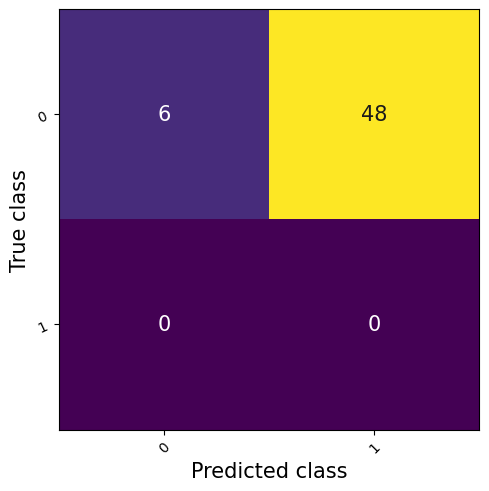

In [12]:
node_mlp_model, node_mlp_result = train_node_classifier(
    model_name="GCN", dataset=dataset, c_hidden=16, num_layers=2, dp_rate=0.1
)

print_results(node_mlp_result)